In [1]:
import os
import threadpoolctl
import warnings
from pathlib import Path
import re
import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as pl
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from rectools.metrics import MAP, calc_metrics, MeanInvUserFreq, Serendipity, HitRate
from rectools.models import ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from implicit.als import AlternatingLeastSquares


from src.metrics import calc_user_auc

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

%load_ext autoreload
%autoreload 2

/Users/aleksandryusov/.pyenv/versions/base/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# Data

In [2]:
data_dir = Path("../data/raw/")

In [3]:
test_pairs = pl.read_csv(data_dir / "test_pairs.csv.csv").with_columns(
    pl.col("item_id").cast(pl.UInt32),
    pl.col("user_id").cast(pl.UInt32)
)
items_meta_df = pl.read_parquet("../data/raw/items_meta.parquet")
users_meta_df = pl.read_parquet("../data/raw/users_meta.parquet")

In [4]:
train_df_als = pl.read_parquet("../data/processed/train_df_als.parquet")
train_df_cb = pl.read_parquet("../data/processed/train_df_cb.parquet")
test_df = pl.read_parquet("../data/processed/test_df.parquet")

## Train / test split

- в финальном датасете берем 20 взаимодействий

In [22]:
test_df = (
    interactions_df
    .group_by("user_id")
    .agg(pl.col("item_id").count().alias("n_items"))
    .filter(pl.col("n_items") > 20)
    .drop("n_items")
    .join(interactions_df, how="left", on="user_id")
    .with_columns(pl.first().cum_count(reverse=True).alias("row_number").over("user_id").alias("rn"))
    .filter(pl.col("rn") <= 20)
    .drop("rn")
)

In [23]:
train_df = (
    interactions_df
    .join(test_df.select("user_id", "item_id"), how="anti", on=["user_id", "item_id"])
)

In [30]:
train_df_stats = (
    train_df
    .lazy()
    .with_columns(
        pl.first().cum_count(reverse=True).over("user_id").alias("rn"),
        pl.first().count().over("user_id").alias("max_rn"),
    )
    .with_columns(
        (pl.col("rn") / pl.col("max_rn")).alias("rn_ratio")
    )
)

train_df_cb = (
    train_df_stats
    .filter(
        pl.col("rn_ratio") < 0.2
    )
    .drop("rn_ratio")
    .collect()
)

train_df_als = (
    train_df_stats
    .filter(
        pl.col("rn_ratio") >= 0.2
    )
    .drop("rn_ratio")
    .collect()
)

## Target

In [5]:
train_df_als_like = (
    train_df_als
    .filter((pl.col("like") + pl.col("dislike")) >= 1)
    .with_columns(weight=pl.col("like").cast(pl.Int8) - pl.col("dislike").cast(pl.Int8))
    .select("user_id", "item_id", pl.col("weight").alias(Columns.Weight), pl.lit(1).alias(Columns.Datetime))
)

train_df_als_like.sample(3)

user_id,item_id,weight,datetime
u32,u32,i8,i32
79860,209841,1,1
83240,287297,1,1
143167,250303,1,1


In [6]:
share_weight = 1
bookmarks_weight = 1
like_weight = 1

train_df_als_like_book_share = (
    train_df_als
    .filter((pl.col("like") + pl.col("dislike") + pl.col("share") + pl.col("bookmarks")) >= 1)
    .with_columns(
        weight=(
            pl.when(pl.col("dislike") == 0).then(
                like_weight * pl.col("like")
                + share_weight * pl.col("share")
                + bookmarks_weight * pl.col("bookmarks")
            ).otherwise(-1).cast(pl.Int8)
        )
    )
    .select("user_id", "item_id", pl.col("weight").alias(Columns.Weight), pl.lit(1).alias(Columns.Datetime))
)

## User features

In [7]:
users_meta_df_flatten = (
    users_meta_df
    .with_columns(pl.col("age").cut(list(range(10, 100, 5))).to_physical().alias("age_group"))
    .melt(id_vars=["user_id"], value_vars=["gender", "age_group"], variable_name="feature", value_name="value")
    .rename({"user_id": "id"})
)

users_meta_df_flatten.sample(3)

id,feature,value
u32,str,u32
84185,"""gender""",1
181845,"""age_group""",2
123589,"""age_group""",2


## Item features

In [8]:
items_meta_df_flatten = (
    items_meta_df
    .with_columns(
        pl.col("duration").cut([25, 60]).to_physical()
    )
    .melt(id_vars=["item_id"], value_vars=["duration"], variable_name="feature", value_name="value")
    .rename({"item_id": "id"})
)

items_meta_df_flatten.sample(3)

id,feature,value
u32,str,u32
333986,"""duration""",0
235861,"""duration""",1
271394,"""duration""",0


# Дополнительные признаки

### Расстояние между эмбеддингами 

In [9]:
def calc_mean_embedding(embeddings: pl.Series):
    return embeddings.to_numpy().mean(axis=0).tolist()
    

user_liked_mean_embeddings = (
    train_df_als
    .filter(pl.col("like") + pl.col("share") + pl.col("bookmarks") >= 1)
    .join(items_meta_df.select("item_id", "source_id", "embeddings"), how="left", on="item_id")
    .group_by("user_id")
    .agg(pl.col("embeddings").map_elements(calc_mean_embedding))
    .with_columns(pl.col("embeddings").list.to_array(32))
)

user_disliked_mean_embeddings = (
    train_df_als
    .filter(pl.col("dislike") == 1)
    .join(items_meta_df.select("item_id", "source_id", "embeddings"), how="left", on="item_id")
    .group_by("user_id")
    .agg(pl.col("embeddings").map_elements(calc_mean_embedding))
    .with_columns(pl.col("embeddings").list.to_array(32))
)

In [22]:
from tqdm.auto import tqdm


def dot_product(x):
    left_embeddings = x.struct[0].to_numpy()
    right_embeddings = x.struct[1].to_numpy()

    dot_product = (left_embeddings * right_embeddings).sum(axis=1)

    return dot_product


def get_emb_sim_features(df_pairs, items_meta_df, user_liked_mean_embeddings, user_disliked_mean_embeddings):
    chunk_size = 100_000
    sliced_result = []
    for df_sample in tqdm(df_pairs.select("user_id", "item_id").iter_slices(n_rows=chunk_size), total=df_pairs.shape[0] // chunk_size + 1):
        df_sample = (
            df_sample
            .join(items_meta_df.select("item_id", "embeddings"), on="item_id", how="inner")
        )

        liked_sim = (
            df_sample
            .join(user_liked_mean_embeddings, on="user_id", how="inner")
            .with_columns(pl.struct("embeddings", "embeddings_right").map_batches(dot_product).alias("liked_embeddings_sim"))
            .select("user_id", "item_id", "liked_embeddings_sim")
        )
    
        disliked_sim = (
            df_sample
            .join(user_disliked_mean_embeddings, on="user_id", how="inner")
            .with_columns(pl.struct("embeddings", "embeddings_right").map_batches(dot_product).alias("disliked_embeddings_sim"))
            .select("user_id", "item_id", "disliked_embeddings_sim")
        )
    
        sliced_result.append((
            df_sample
            .select("user_id", "item_id")
            .join(liked_sim, how="left", on=["user_id", "item_id"])
            .join(disliked_sim, how="left", on=["user_id", "item_id"])
        ))
    
    return (
        pl.concat(sliced_result)
        .with_columns(
            pl.col("liked_embeddings_sim").fill_null(pl.col("liked_embeddings_sim").mean()),
            pl.col("disliked_embeddings_sim").fill_null(pl.col("disliked_embeddings_sim").mean())
        )
    )

In [23]:
train_df_cb_sim_features = get_emb_sim_features(train_df_cb, items_meta_df, user_liked_mean_embeddings, user_disliked_mean_embeddings)
test_df_sim_features = get_emb_sim_features(test_df, items_meta_df, user_liked_mean_embeddings, user_disliked_mean_embeddings)
test_pairs_sim_features = get_emb_sim_features(test_pairs, items_meta_df, user_liked_mean_embeddings, user_disliked_mean_embeddings)

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

### Статистики

In [26]:
from src.data.item_stats import get_item_stats


get_item_stats(train_df_als, items_meta_df, min_users_for_stats=10)

item_id,n_users,mean_like,mean_dislike,mean_share,mean_bookmarks,mean_timespent_ratio,like_dislike_ratio
u32,u32,f64,f64,f64,f64,f64,f64
246865,12,0.0,0.0,0.0,0.0,0.535714,1.0
205168,155,0.012903,0.0,0.006452,0.0,0.471929,1.0
257735,65,0.0,0.0,0.0,0.0,0.500265,1.0
224827,20,0.05,0.0,0.05,0.0,0.72,1.0
291268,3172,0.004414,0.000631,0.002207,0.0,0.372315,0.826087
…,…,…,…,…,…,…,…
63526,10,0.3,0.0,0.0,0.0,0.189474,1.0
246790,55,0.145455,0.0,0.036364,0.0,0.758442,1.0
136672,6892,0.002902,0.000145,0.003482,0.000435,0.580344,0.958333


In [25]:
item_features_extra = (
    train_df_als
    .drop(["rn", "max_rn"])
    .join(items_meta_df.select("item_id", "source_id", "duration"), how="left", on="item_id")
    .with_columns(
        (pl.col("timespent") / pl.col("duration")).alias("timespent_ratio")
    )
    .group_by("item_id")
    .agg(
        pl.first().count().alias("n_users"),
        pl.col("like").mean().alias("mean_like"),
        pl.col("like").sum().alias("sum_like"),
        pl.col("dislike").mean().alias("mean_dislike"),
        pl.col("dislike").sum().alias("sum_dislike"),
        pl.col("share").mean().alias("mean_share"),
        pl.col("share").sum().alias("sum_share"),
        pl.col("bookmarks").mean().alias("mean_bookmarks"),
        pl.col("bookmarks").sum().alias("sum_bookmarks"),
        pl.col("timespent_ratio").mean().alias("mean_timespent_ratio"),
    )
    .with_columns(
        (pl.col("sum_like") + pl.col("sum_share") + pl.col("sum_bookmarks")).alias("sum_positive")
    )
    .with_columns(
        pl.when(pl.col("sum_positive") >= 10).then(
            ((pl.col("sum_positive") - pl.col("sum_dislike")) / (pl.col("sum_positive") + pl.col("sum_dislike")))
        ).otherwise(None).alias("like_dislike_ratio")
    )
    .filter(pl.col("n_users") >= 20)
    .drop(
        "sum_positive",
        "sum_bookmarks",
        "sum_share",
        "sum_dislike",
        "sum_like",
    )
    .with_columns(
        pl.col("like_dislike_ratio").fill_null(1.0)
    )
)

item_features_extra

item_id,n_users,mean_like,mean_dislike,mean_share,mean_bookmarks,mean_timespent_ratio,like_dislike_ratio
u32,u32,f64,f64,f64,f64,f64,f64
322479,13911,0.002372,0.000359,0.0023,0.000144,0.805822,0.861111
187057,186,0.010753,0.0,0.0,0.0,0.620504,1.0
320919,36,0.111111,0.0,0.0,0.0,1.005291,1.0
93472,7552,0.025424,0.000662,0.008475,0.001589,0.622006,0.96337
98179,42,0.142857,0.0,0.02381,0.0,0.450461,1.0
…,…,…,…,…,…,…,…
102371,70,0.057143,0.0,0.042857,0.0,0.319601,1.0
182299,70,0.0,0.0,0.0,0.0,0.631527,1.0
311567,126,0.007937,0.0,0.0,0.0,0.523516,1.0


# Обучение

In [26]:
train_df_als_like.shape[0], train_df_als_like_book_share.shape[0], train_df_cb.shape[0]

(5285530, 6168180, 28292042)

## Обучение ALS на item

In [10]:
from src.models.als import ALSModel

alpha = 10
regularization = 0.01
n_factors = 64
iterations = 30


In [28]:
model_item_id = ALSModel(
    iterations=iterations,
    alpha=alpha,
    regularization=regularization,
    n_factors=n_factors,
    predict_col_name="predict_als_item_id"
).fit(train_df_als_like)

In [29]:
train_df_cb_item_predict = model_item_id.predict_proba(train_df_cb.select("user_id", "item_id"))
test_df_item_predict = model_item_id.predict_proba(test_df.select("user_id", "item_id"))
test_pairs_item_predict = model_item_id.predict_proba(test_pairs.select("user_id", "item_id"))

[01:24:18] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.21195776536737787
[01:24:19] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.2379934938902709
[01:24:20] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.06759570303059596


## Обучение ALS на item на другие положительные взаимодействия

In [30]:
model_item_id_like_book_share = ALSModel(
    iterations=iterations,
    alpha=alpha,
    regularization=regularization,
    n_factors=n_factors,
    predict_col_name="predict_als_item_id_like_book_share"
).fit(train_df_als_like_book_share)

In [31]:
train_df_cb_item_like_book_share_predict = model_item_id_like_book_share.predict_proba(train_df_cb.select("user_id", "item_id"))
test_df_item_like_book_share_predict = model_item_id_like_book_share.predict_proba(test_df.select("user_id", "item_id"))
test_pairs_item_like_book_share_predict = model_item_id_like_book_share.predict_proba(test_pairs.select("user_id", "item_id"))

[01:27:19] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.07067768385187609
[01:27:21] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.10050518028484733
[01:27:21] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.031576562424476776


## Обучение ALS на source_id

In [17]:
from src.models.als_item import ALSSource


model_source_id = ALSSource(
    items_meta_df=items_meta_df,
    iterations=iterations,
    alpha=alpha,
    regularization=regularization,
    n_factors=n_factors,
    predict_col_name="predict_als_item_id_like_book_share",
)

model_source_id.fit(train_df_als_like)

In [18]:
model_source_id.predict_proba(test_pairs)

[12:19:24] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als_item.py:56} INFO - Input df columns: ['user_id', 'item_id']
[12:19:25] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.04607792317905297


user_id,item_id,predict_als_item_id_like_book_share
u32,u32,f32
1,7363,-0.144603
1,73770,-0.00186
1,75700,0.076557
1,81204,0.013697
1,110249,0.156538
…,…,…
183403,235097,0.180878
183403,267411,0.146474
183403,273646,0.003345


In [32]:
train_df_als_like_source_id = (
    train_df_als_like
    .join(items_meta_df.select("item_id", "source_id"), how="inner", on="item_id")
    .drop("item_id")
    .rename({"source_id": "item_id"})
)

train_df_als_like_source_id.sample(3)

user_id,weight,datetime,item_id
u32,i8,i32,u32
139367,1,1,6604
176762,1,1,15882
140994,1,1,1988


In [33]:
model_source_id = ALSModel(
    iterations=iterations,
    alpha=alpha,
    regularization=regularization,
    n_factors=n_factors,
    predict_col_name="predict_als_source_id"
).fit(train_df_als_like_source_id)

In [35]:
train_df_cb = train_df_cb.join(items_meta_df.select("item_id", "source_id"), how="inner", on="item_id")
test_df = test_df.join(items_meta_df.select("item_id", "source_id"), how="inner", on="item_id")
test_pairs = test_pairs.join(items_meta_df.select(pl.col("item_id"), "source_id"), how="inner", on="item_id")

In [36]:
def predict_source_model(df: pl.DataFrame, items_meta_df: pl.DataFrame, model_source_id) -> pl.DataFrame:
    return (
        df
        .select("user_id", "item_id", "source_id")
        .join(
            model_source_id.predict_proba((
                df
                .drop("item_id")
                .rename({"source_id": "item_id"})
                .unique(["user_id", "item_id"])
                .select("user_id", "item_id")
            )),
            how="left", left_on=("user_id", "source_id"), right_on=("user_id", "item_id"),
        )
        .drop("source_id")
    )
    
train_df_cb_source_predict = predict_source_model(train_df_cb, items_meta_df, model_source_id)
test_df_source_predict = predict_source_model(test_df, items_meta_df, model_source_id)
test_pairs_source_predict = predict_source_model(test_pairs, items_meta_df, model_source_id)

[01:29:28] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.19554379419343593
[01:29:30] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.2167973864213579
[01:29:30] {/Users/aleksandryusov/code/competitions/vk/notebooks/../src/models/als.py:126} INFO - ALS: Percent of cold pairs: 0.04607792317905297


## Объединение предсказаний

In [37]:
item_features_extra_columns = [col for col in item_features_extra.columns if col not in ["item_id"]]
item_features_extra_columns

['n_users',
 'mean_like',
 'mean_dislike',
 'mean_share',
 'mean_bookmarks',
 'mean_timespent_ratio',
 'like_dislike_ratio']

In [38]:
emb_sim_columns = [col for col in test_pairs_sim_features.columns if col not in ["user_id", "item_id"]]
emb_sim_columns

['liked_embeddings_sim', 'disliked_embeddings_sim']

In [42]:
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier


cb_train_df = (
    train_df_cb
    .join(train_df_cb_item_predict, on=["user_id", "item_id"], how="left")
    .join(train_df_cb_source_predict, on=["user_id", "item_id"], how="left")
    .join(train_df_cb_item_like_book_share_predict, on=["user_id", "item_id"], how="left")
    .join(train_df_cb_sim_features, on=["user_id", "item_id"], how="left")
    .join(items_meta_df, on="item_id")
    .join(item_features_extra, on="item_id")
    .drop("item_id")
    .select(
        "user_id", 
        "predict_als_item_id", "predict_als_source_id", "predict_als_item_id_like_book_share", "duration",
        *item_features_extra_columns,
        *emb_sim_columns,
        pl.col("like").cast(int), pl.col("dislike").cast(int),
        (pl.col("like") - pl.col("dislike")).alias("target"),
        *[
            pl.col("embeddings").arr.get(i).alias(f"e{i}")
            for i in range(32)
        ]
    )
    .sample(1_000_000, seed=24)
    .sort("user_id")
    .to_pandas()
)

cb_test_df = (
    test_df
    # .sample(100_000, seed=42)
    .join(test_df_item_predict, on=["user_id", "item_id"], how="left")
    .join(test_df_source_predict, on=["user_id", "item_id"], how="left")
    .join(test_df_item_like_book_share_predict, on=["user_id", "item_id"], how="left")
    .join(test_df_sim_features, on=["user_id", "item_id"], how="left")
    .join(items_meta_df, on="item_id")
    .join(item_features_extra, on="item_id")
    .select(
        "user_id", "item_id",
        "predict_als_item_id", "predict_als_source_id", "predict_als_item_id_like_book_share", "duration",
        *item_features_extra_columns,
        *emb_sim_columns,
        pl.col("like").cast(int), pl.col("dislike").cast(int),
        (pl.col("like") - pl.col("dislike")).alias("target"),
        *[
            pl.col("embeddings").arr.get(i).alias(f"e{i}")
            for i in range(32)
        ]
    )
    .to_pandas()
)

In [43]:
feature_columns = [
    "predict_als_item_id", 
    "predict_als_source_id", 
    "predict_als_item_id_like_book_share",
    "duration",
    *emb_sim_columns,
    *item_features_extra_columns,
    *[f"e{i}" for i in range(32)]
]

In [44]:
from catboost import CatBoostRanker


cb_model = CatBoostRanker(
    iterations=500, 
    depth=6, 
    random_seed=32, 
    verbose=0, 
    loss_function="PairLogit"
)
cb_model.fit(cb_train_df[feature_columns], cb_train_df["target"], group_id=cb_train_df["user_id"])
test_predict = cb_model.predict(cb_test_df[feature_columns])

In [45]:
test_df_final_prediction = (
    pl.from_pandas(cb_test_df[["user_id", "target", "item_id", "predict_als_item_id", "predict_als_source_id", "predict_als_item_id_like_book_share"]])
    .with_columns(
        pl.Series(test_predict).alias("prediction")
    )
)

test_df_final_prediction

user_id,target,item_id,predict_als_item_id,predict_als_source_id,predict_als_item_id_like_book_share,prediction
u32,u8,u32,f32,f32,f32,f64
58730,0,163471,0.003038,0.021059,0.002342,0.089235
58730,0,28681,0.001204,-0.018045,0.002735,0.077177
58730,0,61644,-0.000013,0.116409,0.000136,-0.105965
58730,0,230039,0.000072,0.012224,0.000263,-0.554528
58730,0,162628,0.004473,0.198819,0.003995,0.52302
…,…,…,…,…,…,…
42045,0,50200,-1.0,-1.0,-1.0,-0.819945
42045,0,168423,-1.0,-1.0,-1.0,-1.145419
42045,0,122809,-1.0,-1.0,-1.0,-0.716433


<Axes: ylabel='Frequency'>

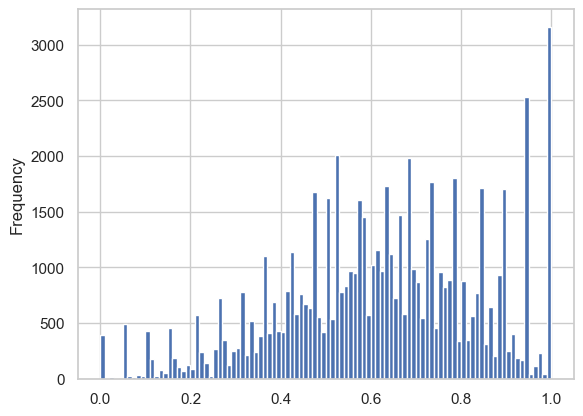

In [46]:
metrics_final = calc_user_auc(
    df=test_df_final_prediction,
    predict_col="prediction", 
    target_col="target"
)

metrics_final["rocauc"].to_pandas().plot.hist(bins=100)

In [47]:
for predict_col in ("predict_als_item_id", "predict_als_source_id", "prediction", "predict_als_item_id_like_book_share"):
    metric_value = calc_user_auc(
        df=test_df_final_prediction,
        predict_col=predict_col, 
        target_col="target"
    )["rocauc"].mean()

    print(f"{predict_col}: {metric_value:.5f}")

predict_als_item_id: 0.56427
predict_als_source_id: 0.53814
prediction: 0.62140
predict_als_item_id_like_book_share: 0.56261


In [29]:
for predict_col in ("predict_als_item_id", "predict_als_source_id", "prediction", "predict_als_item_id_like_book_share"):
    metric_value = calc_user_auc(
        df=test_df_final_prediction,
        predict_col=predict_col, 
        target_col="target"
    )["rocauc"].mean()

    print(f"{predict_col}: {metric_value:.5f}")

predict_als_item_id: 0.56427
predict_als_source_id: 0.53814
prediction: 0.62043
predict_als_item_id_like_book_share: 0.56261


In [24]:
for predict_col in ("predict_als_item_id", "predict_als_source_id", "prediction", "predict_als_item_id_like_book_share"):
    metric_value = calc_user_auc(
        df=test_df_final_prediction,
        predict_col=predict_col, 
        target_col="target"
    )["rocauc"].mean()

    print(f"{predict_col}: {metric_value:.5f}")

predict_als_item_id: 0.56172
predict_als_source_id: 0.53815
prediction: 0.58631
predict_als_item_id_like_book_share: 0.55986


In [54]:
for predict_col in ("predict_als_item_id", "predict_als_source_id", "prediction", "predict_als_item_id_like_book_share"):
    metric_value = calc_user_auc(
        df=test_df_final_prediction,
        predict_col=predict_col, 
        target_col="target"
    )["rocauc"].mean()

    print(f"{predict_col}: {metric_value:.5f}")

predict_als_item_id: 0.56123
predict_als_source_id: 0.53745
prediction: 0.58624
predict_als_item_id_like_book_share: 0.55870


In [50]:
for predict_col in ("predict_als_item_id", "predict_als_source_id", "prediction", "predict_als_item_id_like_book_share"):
    metric_value = calc_user_auc(
        df=test_df_final_prediction,
        predict_col=predict_col, 
        target_col="target"
    )["rocauc"].mean()

    print(f"{predict_col}: {metric_value:.5f}")

predict_als_item_id: 0.56123
predict_als_source_id: 0.53745
prediction: 0.58460
predict_als_item_id_like_book_share: 0.55870


In [45]:
for predict_col in ("predict_als_item_id", "predict_als_source_id", "prediction", "predict_als_item_id_like_book_share"):
    metric_value = calc_user_auc(
        df=test_df_final_prediction,
        predict_col=predict_col, 
        target_col="target"
    )["rocauc"].mean()

    print(f"{predict_col}: {metric_value:.5f}")

predict_als_item_id: 0.56123
predict_als_source_id: 0.53745
prediction: 0.57813
predict_als_item_id_like_book_share: 0.55870


# Финальное предсказание

In [49]:
cb_test_pairs_df = (
    test_pairs
    # .sample(100_000, seed=42)
    .join(test_pairs_item_predict, on=["user_id", "item_id"], how="left")
    .join(test_pairs_source_predict, on=["user_id", "item_id"], how="left")
    .join(test_pairs_item_like_book_share_predict, on=["user_id", "item_id"], how="left")
    .with_columns(pl.col("item_id").cast(pl.UInt32))
    .join(items_meta_df, on="item_id", how="left")
    .join(item_features_extra, on="item_id", how="left")
    .join(test_df_sim_features, on=["user_id", "item_id"], how="left")
    .select(
        "user_id", "item_id",
        "predict_als_item_id", "predict_als_source_id", "predict_als_item_id_like_book_share", "duration",
        *emb_sim_columns,
        *item_features_extra_columns,
        *[
            pl.col("embeddings").arr.get(i).alias(f"e{i}")
            for i in range(32)
        ]
    )
    .to_pandas()
)

In [50]:
from datetime import datetime

(
    cb_test_pairs_df
    .assign(predict=cb_model.predict(cb_test_pairs_df[feature_columns]))
    [[
        "user_id",
        "item_id",
        "predict"
    ]]
    .to_csv(f'../data/submissions/{int(datetime.now().timestamp())}_submission.csv', index=False)
)